# ML interface example code

Here's example code for the ML functionality I'd like to have in the final version. Please don't hesitate to ping me if you've got questions/issues/suggestions/requests/objections. There's usually more than one way to implement this stuff.

For example data, I'm using the UCMerced Land Use Dataset, which I downloaded and converted to PNG: http://weegee.vision.ucmerced.edu/datasets/landuse.html

I have example code here for a couple feature generators; the simplest one should give (at best) mediocre results but should get the point across.

* Since you're mostly working with JSON I defaulted to inputting/outputting dictionaries wherever it made sense
* For images/features/probabilities, `numpy` arrays are usually my default data structure. I did everything in-memory here but it could be modified to pull from sqlite or something.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import os
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [2]:
imdir = "UCMerced_pngs/"
imfiles = [os.path.join(imdir,x) for x in os.listdir(imdir)]
len(imfiles)

2100

# load a feature extractor


In [3]:
def build_simple_feature_extractor():
    """
    This won't work for crap but should be a simple test case that doesn't
    require a GPU
    """
    inpt = tf.keras.layers.Input((None, None, 3))
    net = tf.keras.layers.Conv2D(128,3)(inpt)
    net = tf.keras.layers.GlobalAveragePooling2D()(net)
    return tf.keras.Model(inpt, net)

In [4]:
def build_generic_feature_extractor():
    """
    Convolutional networks pretrained on ImageNet are often used
    as general-purpose feature extractors. Even though ImageNet
    is very different from the data we want to look at, this
    baseline can take some work to beat.
    
    This extractor will be pretty slow without a GPU.
    """
    fcn = tf.keras.applications.VGG16(weights="imagenet", include_top=False)
    inpt = tf.keras.layers.Input((None, None, 3))
    net = fcn(inpt)
    net = tf.keras.layers.GlobalAveragePooling2D()(net)
    return tf.keras.Model(inpt, net)

In [5]:
def load_feature_extractor_from_file(filepath):
    """
    Loading a saved extractor is pretty straightforward
    """
    return tf.keras.models.load_model(filepath)

In [6]:
feature_extractor = build_simple_feature_extractor()

# precompute features

There are a few different ways to get predictions from a `keras` model. One option is to pull from a Python generator object.

The `keras` model for a convolutional network expects inputs as a rank-4 tensor: the shape is `(num_images_in_batch, height, width, num_channels)`. Also note that, by convention, inputs to a CNN are normalized to be between 0 and 1 (which for 8-bit RGB images means converting to a float and dividing by 255).

In [7]:
def image_generator():
    """
    The innards don't matter so long as an image comes out.
    """
    for i in imfiles:
        # load image and make sure the shape is consistent
        img = Image.open(i).resize((256,256))
        # convert to a numpy array, make it a float and normalize to
        # the unit interval
        img_arr = np.array(img).astype(np.float32)/255
        # tensorflow expects the array to be rank-4 tensor,
        # of shape (batch, height, width, num_channels)
        yield np.expand_dims(img_arr, 0)

This computation should only need to happen once per project, before we start.

Also note that we need to know *a prior* the number of steps it will take (`num_images/batch_size`):

In [8]:
%%time
features = feature_extractor.predict_generator(image_generator(), steps=len(imfiles))
# probably a good idea to standardize all the features just in case the network has
# one or two wonky outputs
features = StandardScaler().fit_transform(features)

CPU times: user 3min 22s, sys: 1.58 s, total: 3min 24s
Wall time: 1min 22s


In [9]:
features.shape

(2100, 128)

# retrieve similar images

Now that we have a dense vector representation of each image, we can do retrieval as if this were latent semantic indexing.

Fit a ball tree:

In [10]:
%%time
knn = NearestNeighbors(algorithm='ball_tree').fit(features)

CPU times: user 26.3 ms, sys: 3.61 ms, total: 29.9 ms
Wall time: 35.6 ms


Pick an image to query off of:

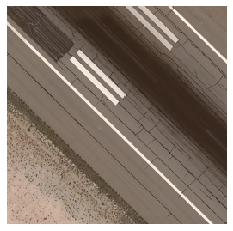

In [11]:
query_index = 6
plt.imshow(Image.open(imfiles[query_index]))
plt.axis(False);

Print out the nearest neighbors:

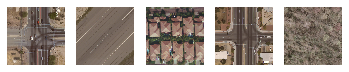

In [12]:
neighbors = knn.kneighbors(np.expand_dims(features[query_index,:],0), n_neighbors=6, return_distance=False)

for i in range(1,6):
    plt.subplot(1,5,i)
    plt.imshow(Image.open(imfiles[neighbors[0,i]]))
    plt.axis(False)

# Few-shot supervised learning

We'd like to be able to train a simple machine learning model on top of these features for a specific task.

In [13]:
def shannon_entropy(x, eps=1e-5):
    # compute shannon information entropies for a 2D 
    # array of probabilities
    x = np.maximum(np.minimum(x, 1-eps), eps)
    return (-1*x*np.log2(x)).sum(axis=1)


class Classifier():
    """
    Simple widget for training a logistic regression classifier from feature vectors.
    """
    def __init__(self, featvecs, labeldict, C=1e6):
        """
        Fit a fine-tuning model using logistic regression
        
        :labeldict: dictionary mapping image index to a label
        :featvecs: 2D array of feature vectors; dimensions (num_images, feature_dimension)
        :C: inverse regularization strength
        """
        label_indices = np.array(list(labeldict.keys()))
        
        X = featvecs[label_indices]
        Y = [labeldict[i] for i in label_indices]
        self.model = LogisticRegression(C=C, max_iter=1000).fit(X,Y)
        
    def _check_if_model_trained(self):
        assert hasattr(self, "model"), "train a model first, fool"
        
    def predict(self, featvecs, index=None):
        """
        Return a dictionary of indices to categories.
        
        :featvecs: 2D array of feature vectors; dimensions (num_images, feature_dimension)
        :index: 1D numpy array of indices to predict on. if None, predict on entire 
            feature matrix
        """
        self._check_if_model_trained()
        if index is None:
            index = np.arange(featvecs.shape[0])
        preds = self.model.predict(featvecs[index])
        return dict(zip(index, preds))
    
    def uncertainty_sample(self, featvecs, index=None, num_to_sample=5):
        """
        Return an array of indices corresponding to the highest-uncertainty
        images- having a human label these will tend to be more effective
        than just labeling random images.
        
        :featvecs: 2D array of feature vectors; dimensions (num_images, feature_dimension)
        :index: 1D numpy array of indices to sample from. if None, use entire
            feature matrix
        :num_to_sample: number of image indices to return
        """
        self._check_if_model_trained()
        if index is None:
            index = np.arange(features.shape[0])
            
        probs = self.model.predict_proba(featvecs[index])
        entropies = shannon_entropy(probs)
        biggest_entropies = entropies.argsort()[::-1][:num_to_sample]
        return index[biggest_entropies]

We'll build a dictionary mapping indices to labels- 5 randomly-chosen positive cases and 20 randomly-chosen negatives:

In [14]:
labels = {}
N = len(imfiles)

for i in np.random.choice([i for i in range(N) if "airplane" in imfiles[i]], size=5, replace=False):
    labels[i] = "airplane"
    

for i in np.random.choice([i for i in range(N) if "airplane" not in imfiles[i]], size=20, replace=False):
    labels[i] = "not_airplane"
    
len(labels)    

25

Train a logistic regression classifier:

In [15]:
classifier = Classifier(features, labels)

Make predictions as an `index:category` dictionary, that we could combine with image locations to build a raster or polygons of predictions on a map:

In [16]:
predictions = classifier.predict(features)
predictions[12]

'not_airplane'

Overall performance:

In [17]:
true_positives = 0
false_negatives = 0
true_negatives = 0
false_positives = 0

for i in range(len(imfiles)):
    if i not in labels:
        pred = predictions[i]
        # positive case
        if "airplane" in imfiles[i]:
            if pred == "airplane":
                true_positives += 1
            else:
                false_negatives += 1
        # negative case
        else:
            if pred == "airplane":
                false_positives += 1
            else:
                true_negatives += 1
                
print("True positives:", true_positives)
print("False negatives:", false_negatives)
print("True negatives:", true_negatives)
print("False positives:", false_positives)
print("Accuracy:", round((true_positives+true_negatives)/(len(imfiles)-len(labels)), 2))

True positives: 56
False negatives: 39
True negatives: 1475
False positives: 505
Accuracy: 0.74


Generally a model built with only a few examples won't work great- but we can use it as a guide to see where we'd get the most improvement for our time if we labeled more:

In [18]:
# find the indices that we haven't labeled yet
unlabeled_indices = np.array([i for i in np.arange(features.shape[0]) if i not in labels])
# request a recommendation for what to label next
samples_to_label = classifier.uncertainty_sample(features, unlabeled_indices, 5)

Here are the images the classifier was least confident about:

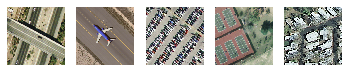

In [19]:
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(Image.open(imfiles[samples_to_label[i]]))
    plt.axis(False);